# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
from common_utils import CustomDataset, loss_fn, split_dataset, preprocess_dataset, generate_cv_folds, EarlyStopper, train_loop, test_loop

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], test_size=0.3, random_state=0)


In [3]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super(MLP, self).__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(no_hidden, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(128, no_labels),
            nn.Sigmoid()            
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [4]:
def initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, bs):
    # YOUR CODE HERE
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)
    return train_dataloader, test_dataloader

def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    train_dataloader, test_dataloader = initialise_loaders(X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
    epochs = 100
   
    tr_loss, tr_correct = [], []
    te_loss, te_correct = [], []
    epoch_training_time_list = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    for t in range(epochs):
        epoch_starttime = time.time()                
        train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
        epoch_training_time = time.time()-epoch_starttime
        epoch_training_time_list.append(epoch_training_time)

        test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

        tr_loss.append(train_loss), tr_correct.append(train_correct)
        te_loss.append(test_loss), te_correct.append(test_correct)

        print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    train_accuracies = tr_correct
    train_losses = tr_loss
    test_accuracies = te_correct
    test_losses = te_loss
    times = epoch_training_time_list
    
    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [5]:
train_accuracies_optimal = []
test_accuracies_optimal = []

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    cross_validation_accuracies = {64: [], 128: [], 256: []}
    cross_validation_times = {64: [], 128: [], 256: []}
#     print(parameters)
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds(parameters, X_train, y_train)
    
    for i in parameters:
        for fold in range(5):
            model = MLP(no_features=X_train_scaled_dict[i][fold].shape[1], no_hidden=i, no_labels=2)
            
            X_train_scaled = X_train_scaled_dict[i][fold]
            y_train2 = y_train_dict[i][fold]
            X_val_scaled = X_val_scaled_dict[i][fold]
            y_val2 = y_val_dict[i][fold]
            print(f"neurons: {i}, fold: {fold+1}")
            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
            
            cross_validation_accuracies[i].append(test_accuracies[-1])
            cross_validation_times[i].append(times[-1])
            
            if i == 256:
                train_accuracies_optimal.extend(train_accuracies)
                test_accuracies_optimal.extend(test_accuracies)
            
    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
num_neurons = [64, 128, 256]
optimal_bs = 256
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

neurons: 64, fold: 1


C:\Users\kp27d\anaconda3\envs\pytorchenv\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train_accuracy: 50.56%, Train_loss: 0.691790, Test_accuracy: 55.69%, Test_loss: 0.687981
Epoch 2: Train_accuracy: 56.01%, Train_loss: 0.684831, Test_accuracy: 57.76%, Test_loss: 0.677884
Epoch 3: Train_accuracy: 57.62%, Train_loss: 0.676456, Test_accuracy: 59.48%, Test_loss: 0.667385
Epoch 4: Train_accuracy: 59.90%, Train_loss: 0.667132, Test_accuracy: 62.03%, Test_loss: 0.652508
Epoch 5: Train_accuracy: 61.15%, Train_loss: 0.660681, Test_accuracy: 61.43%, Test_loss: 0.660189
Epoch 6: Train_accuracy: 61.29%, Train_loss: 0.656365, Test_accuracy: 62.68%, Test_loss: 0.651845
Epoch 7: Train_accuracy: 62.81%, Train_loss: 0.646979, Test_accuracy: 61.91%, Test_loss: 0.655774
Epoch 8: Train_accuracy: 63.66%, Train_loss: 0.638693, Test_accuracy: 63.03%, Test_loss: 0.650067
Epoch 9: Train_accuracy: 64.35%, Train_loss: 0.636760, Test_accuracy: 64.22%, Test_loss: 0.644639
Epoch 10: Train_accuracy: 66.21%, Train_loss: 0.626396, Test_accuracy: 62.68%, Test_loss: 0.649913
Epoch 11: Train_acc

Epoch 84: Train_accuracy: 83.28%, Train_loss: 0.471942, Test_accuracy: 69.67%, Test_loss: 0.597060
Epoch 85: Train_accuracy: 84.06%, Train_loss: 0.468643, Test_accuracy: 70.56%, Test_loss: 0.595622
Epoch 86: Train_accuracy: 83.93%, Train_loss: 0.467962, Test_accuracy: 70.20%, Test_loss: 0.599984
Epoch 87: Train_accuracy: 83.84%, Train_loss: 0.469759, Test_accuracy: 68.07%, Test_loss: 0.612278
Epoch 88: Train_accuracy: 84.19%, Train_loss: 0.465252, Test_accuracy: 69.14%, Test_loss: 0.606303
Epoch 89: Train_accuracy: 83.85%, Train_loss: 0.468645, Test_accuracy: 70.68%, Test_loss: 0.588611
Epoch 90: Train_accuracy: 84.19%, Train_loss: 0.466533, Test_accuracy: 71.27%, Test_loss: 0.587847
Epoch 91: Train_accuracy: 84.64%, Train_loss: 0.461627, Test_accuracy: 69.79%, Test_loss: 0.594223
Epoch 92: Train_accuracy: 84.21%, Train_loss: 0.465794, Test_accuracy: 69.79%, Test_loss: 0.607657
Epoch 93: Train_accuracy: 84.14%, Train_loss: 0.463520, Test_accuracy: 67.95%, Test_loss: 0.612777
Epoch 94: 

Epoch 67: Train_accuracy: 81.48%, Train_loss: 0.489641, Test_accuracy: 69.02%, Test_loss: 0.602789
Epoch 68: Train_accuracy: 82.00%, Train_loss: 0.486377, Test_accuracy: 70.14%, Test_loss: 0.594477
Epoch 69: Train_accuracy: 81.94%, Train_loss: 0.486986, Test_accuracy: 68.42%, Test_loss: 0.608089
Epoch 70: Train_accuracy: 82.40%, Train_loss: 0.482974, Test_accuracy: 69.79%, Test_loss: 0.598304
Epoch 71: Train_accuracy: 82.17%, Train_loss: 0.484692, Test_accuracy: 69.85%, Test_loss: 0.597925
Epoch 72: Train_accuracy: 82.20%, Train_loss: 0.485728, Test_accuracy: 69.37%, Test_loss: 0.604057
Epoch 73: Train_accuracy: 82.42%, Train_loss: 0.482037, Test_accuracy: 70.68%, Test_loss: 0.595461
Epoch 74: Train_accuracy: 82.80%, Train_loss: 0.478862, Test_accuracy: 68.90%, Test_loss: 0.606080
Epoch 75: Train_accuracy: 82.45%, Train_loss: 0.482893, Test_accuracy: 70.26%, Test_loss: 0.595954
Epoch 76: Train_accuracy: 82.45%, Train_loss: 0.483117, Test_accuracy: 69.79%, Test_loss: 0.602252
Epoch 77: 

Epoch 51: Train_accuracy: 79.26%, Train_loss: 0.513672, Test_accuracy: 67.77%, Test_loss: 0.617013
Epoch 52: Train_accuracy: 80.70%, Train_loss: 0.500785, Test_accuracy: 69.02%, Test_loss: 0.605704
Epoch 53: Train_accuracy: 80.52%, Train_loss: 0.503580, Test_accuracy: 67.06%, Test_loss: 0.618663
Epoch 54: Train_accuracy: 80.34%, Train_loss: 0.502590, Test_accuracy: 67.00%, Test_loss: 0.630508
Epoch 55: Train_accuracy: 79.81%, Train_loss: 0.506372, Test_accuracy: 65.28%, Test_loss: 0.634051
Epoch 56: Train_accuracy: 80.12%, Train_loss: 0.501344, Test_accuracy: 67.71%, Test_loss: 0.612706
Epoch 57: Train_accuracy: 80.68%, Train_loss: 0.499578, Test_accuracy: 67.54%, Test_loss: 0.620652
Epoch 58: Train_accuracy: 80.76%, Train_loss: 0.495863, Test_accuracy: 68.48%, Test_loss: 0.616664
Epoch 59: Train_accuracy: 80.91%, Train_loss: 0.498645, Test_accuracy: 68.25%, Test_loss: 0.608875
Epoch 60: Train_accuracy: 81.75%, Train_loss: 0.491609, Test_accuracy: 68.13%, Test_loss: 0.615547
Epoch 61: 

Epoch 34: Train_accuracy: 76.70%, Train_loss: 0.536552, Test_accuracy: 67.18%, Test_loss: 0.622161
Epoch 35: Train_accuracy: 76.85%, Train_loss: 0.531910, Test_accuracy: 66.35%, Test_loss: 0.628531
Epoch 36: Train_accuracy: 77.23%, Train_loss: 0.530085, Test_accuracy: 66.23%, Test_loss: 0.629026
Epoch 37: Train_accuracy: 78.12%, Train_loss: 0.523683, Test_accuracy: 67.12%, Test_loss: 0.622513
Epoch 38: Train_accuracy: 78.68%, Train_loss: 0.519130, Test_accuracy: 67.48%, Test_loss: 0.619348
Epoch 39: Train_accuracy: 78.76%, Train_loss: 0.517307, Test_accuracy: 66.59%, Test_loss: 0.630064
Epoch 40: Train_accuracy: 78.48%, Train_loss: 0.520149, Test_accuracy: 66.29%, Test_loss: 0.635585
Epoch 41: Train_accuracy: 77.23%, Train_loss: 0.528599, Test_accuracy: 65.70%, Test_loss: 0.632642
Epoch 42: Train_accuracy: 78.49%, Train_loss: 0.519638, Test_accuracy: 66.77%, Test_loss: 0.618083
Epoch 43: Train_accuracy: 79.71%, Train_loss: 0.510871, Test_accuracy: 68.19%, Test_loss: 0.609861
Epoch 44: 

Epoch 17: Train_accuracy: 70.66%, Train_loss: 0.588996, Test_accuracy: 63.54%, Test_loss: 0.638345
Epoch 18: Train_accuracy: 71.22%, Train_loss: 0.585832, Test_accuracy: 64.97%, Test_loss: 0.630459
Epoch 19: Train_accuracy: 71.88%, Train_loss: 0.579253, Test_accuracy: 65.26%, Test_loss: 0.630723
Epoch 20: Train_accuracy: 72.27%, Train_loss: 0.576418, Test_accuracy: 65.86%, Test_loss: 0.630587
Epoch 21: Train_accuracy: 71.74%, Train_loss: 0.575627, Test_accuracy: 64.43%, Test_loss: 0.639420
Epoch 22: Train_accuracy: 73.33%, Train_loss: 0.568542, Test_accuracy: 64.20%, Test_loss: 0.634759
Epoch 23: Train_accuracy: 73.07%, Train_loss: 0.566790, Test_accuracy: 65.15%, Test_loss: 0.640564
Epoch 24: Train_accuracy: 72.72%, Train_loss: 0.566065, Test_accuracy: 66.57%, Test_loss: 0.625440
Epoch 25: Train_accuracy: 73.09%, Train_loss: 0.564315, Test_accuracy: 66.63%, Test_loss: 0.629760
Epoch 26: Train_accuracy: 73.92%, Train_loss: 0.558926, Test_accuracy: 64.55%, Test_loss: 0.640824
Epoch 27: 

Epoch 100: Train_accuracy: 84.26%, Train_loss: 0.465308, Test_accuracy: 68.82%, Test_loss: 0.607091
neurons: 128, fold: 1
Epoch 1: Train_accuracy: 52.21%, Train_loss: 0.691048, Test_accuracy: 58.06%, Test_loss: 0.685172
Epoch 2: Train_accuracy: 56.30%, Train_loss: 0.682801, Test_accuracy: 58.41%, Test_loss: 0.674602
Epoch 3: Train_accuracy: 58.58%, Train_loss: 0.672993, Test_accuracy: 59.48%, Test_loss: 0.663175
Epoch 4: Train_accuracy: 60.66%, Train_loss: 0.660732, Test_accuracy: 61.02%, Test_loss: 0.654164
Epoch 5: Train_accuracy: 61.64%, Train_loss: 0.653160, Test_accuracy: 61.55%, Test_loss: 0.657369
Epoch 6: Train_accuracy: 63.74%, Train_loss: 0.642579, Test_accuracy: 63.21%, Test_loss: 0.648985
Epoch 7: Train_accuracy: 64.27%, Train_loss: 0.632776, Test_accuracy: 61.55%, Test_loss: 0.651206
Epoch 8: Train_accuracy: 65.44%, Train_loss: 0.629392, Test_accuracy: 63.15%, Test_loss: 0.643767
Epoch 9: Train_accuracy: 67.19%, Train_loss: 0.617092, Test_accuracy: 63.74%, Test_loss: 0.638

Epoch 84: Train_accuracy: 88.61%, Train_loss: 0.424539, Test_accuracy: 71.80%, Test_loss: 0.581146
Epoch 85: Train_accuracy: 88.89%, Train_loss: 0.422024, Test_accuracy: 72.45%, Test_loss: 0.575399
Epoch 86: Train_accuracy: 88.61%, Train_loss: 0.422015, Test_accuracy: 71.86%, Test_loss: 0.581370
Epoch 87: Train_accuracy: 88.14%, Train_loss: 0.429241, Test_accuracy: 71.80%, Test_loss: 0.579075
Epoch 88: Train_accuracy: 88.55%, Train_loss: 0.422506, Test_accuracy: 71.45%, Test_loss: 0.588065
Epoch 89: Train_accuracy: 88.43%, Train_loss: 0.426305, Test_accuracy: 71.39%, Test_loss: 0.584802
Epoch 90: Train_accuracy: 88.67%, Train_loss: 0.423868, Test_accuracy: 70.56%, Test_loss: 0.591591
Epoch 91: Train_accuracy: 88.27%, Train_loss: 0.427651, Test_accuracy: 70.85%, Test_loss: 0.591783
Epoch 92: Train_accuracy: 88.19%, Train_loss: 0.427262, Test_accuracy: 71.86%, Test_loss: 0.582327
Epoch 93: Train_accuracy: 88.24%, Train_loss: 0.426532, Test_accuracy: 72.63%, Test_loss: 0.582856
Epoch 94: 

Epoch 67: Train_accuracy: 85.45%, Train_loss: 0.452806, Test_accuracy: 70.68%, Test_loss: 0.593495
Epoch 68: Train_accuracy: 86.22%, Train_loss: 0.445935, Test_accuracy: 71.62%, Test_loss: 0.585546
Epoch 69: Train_accuracy: 86.55%, Train_loss: 0.443346, Test_accuracy: 71.86%, Test_loss: 0.585186
Epoch 70: Train_accuracy: 86.91%, Train_loss: 0.439078, Test_accuracy: 72.45%, Test_loss: 0.573361
Epoch 71: Train_accuracy: 86.95%, Train_loss: 0.440032, Test_accuracy: 70.73%, Test_loss: 0.584986
Epoch 72: Train_accuracy: 85.96%, Train_loss: 0.446852, Test_accuracy: 72.22%, Test_loss: 0.576097
Epoch 73: Train_accuracy: 87.53%, Train_loss: 0.436444, Test_accuracy: 72.10%, Test_loss: 0.574257
Epoch 74: Train_accuracy: 87.02%, Train_loss: 0.441378, Test_accuracy: 71.68%, Test_loss: 0.582009
Epoch 75: Train_accuracy: 87.26%, Train_loss: 0.436980, Test_accuracy: 72.04%, Test_loss: 0.583159
Epoch 76: Train_accuracy: 86.68%, Train_loss: 0.444674, Test_accuracy: 71.39%, Test_loss: 0.585921
Epoch 77: 

Epoch 50: Train_accuracy: 83.14%, Train_loss: 0.473390, Test_accuracy: 69.96%, Test_loss: 0.591424
Epoch 51: Train_accuracy: 83.85%, Train_loss: 0.470055, Test_accuracy: 69.91%, Test_loss: 0.597850
Epoch 52: Train_accuracy: 83.26%, Train_loss: 0.475587, Test_accuracy: 69.73%, Test_loss: 0.598716
Epoch 53: Train_accuracy: 84.34%, Train_loss: 0.465612, Test_accuracy: 71.03%, Test_loss: 0.589875
Epoch 54: Train_accuracy: 83.85%, Train_loss: 0.470210, Test_accuracy: 70.02%, Test_loss: 0.597142
Epoch 55: Train_accuracy: 84.45%, Train_loss: 0.466504, Test_accuracy: 70.62%, Test_loss: 0.591497
Epoch 56: Train_accuracy: 83.87%, Train_loss: 0.470745, Test_accuracy: 69.37%, Test_loss: 0.598629
Epoch 57: Train_accuracy: 84.77%, Train_loss: 0.461484, Test_accuracy: 68.48%, Test_loss: 0.612660
Epoch 58: Train_accuracy: 85.22%, Train_loss: 0.457147, Test_accuracy: 69.73%, Test_loss: 0.596304
Epoch 59: Train_accuracy: 85.02%, Train_loss: 0.457602, Test_accuracy: 69.67%, Test_loss: 0.595631
Epoch 60: 

Epoch 33: Train_accuracy: 80.65%, Train_loss: 0.502101, Test_accuracy: 67.42%, Test_loss: 0.618038
Epoch 34: Train_accuracy: 80.65%, Train_loss: 0.498713, Test_accuracy: 68.01%, Test_loss: 0.612059
Epoch 35: Train_accuracy: 80.76%, Train_loss: 0.497230, Test_accuracy: 68.25%, Test_loss: 0.610747
Epoch 36: Train_accuracy: 80.30%, Train_loss: 0.500371, Test_accuracy: 67.54%, Test_loss: 0.615816
Epoch 37: Train_accuracy: 80.88%, Train_loss: 0.498397, Test_accuracy: 66.47%, Test_loss: 0.627903
Epoch 38: Train_accuracy: 81.47%, Train_loss: 0.490722, Test_accuracy: 67.59%, Test_loss: 0.616144
Epoch 39: Train_accuracy: 81.69%, Train_loss: 0.489763, Test_accuracy: 66.59%, Test_loss: 0.624386
Epoch 40: Train_accuracy: 82.43%, Train_loss: 0.481830, Test_accuracy: 69.08%, Test_loss: 0.605232
Epoch 41: Train_accuracy: 82.64%, Train_loss: 0.482280, Test_accuracy: 68.66%, Test_loss: 0.610824
Epoch 42: Train_accuracy: 83.02%, Train_loss: 0.479470, Test_accuracy: 68.78%, Test_loss: 0.607693
Epoch 43: 

Epoch 17: Train_accuracy: 73.40%, Train_loss: 0.563453, Test_accuracy: 65.38%, Test_loss: 0.632410
Epoch 18: Train_accuracy: 74.70%, Train_loss: 0.557566, Test_accuracy: 66.86%, Test_loss: 0.618614
Epoch 19: Train_accuracy: 74.27%, Train_loss: 0.558253, Test_accuracy: 66.21%, Test_loss: 0.622724
Epoch 20: Train_accuracy: 75.15%, Train_loss: 0.550269, Test_accuracy: 67.28%, Test_loss: 0.623500
Epoch 21: Train_accuracy: 75.53%, Train_loss: 0.547789, Test_accuracy: 66.39%, Test_loss: 0.623170
Epoch 22: Train_accuracy: 76.08%, Train_loss: 0.541562, Test_accuracy: 66.98%, Test_loss: 0.620635
Epoch 23: Train_accuracy: 75.84%, Train_loss: 0.539639, Test_accuracy: 65.56%, Test_loss: 0.628472
Epoch 24: Train_accuracy: 76.88%, Train_loss: 0.536230, Test_accuracy: 67.52%, Test_loss: 0.613100
Epoch 25: Train_accuracy: 76.91%, Train_loss: 0.530980, Test_accuracy: 67.52%, Test_loss: 0.621279
Epoch 26: Train_accuracy: 77.89%, Train_loss: 0.526457, Test_accuracy: 67.93%, Test_loss: 0.609105
Epoch 27: 

Epoch 100: Train_accuracy: 88.98%, Train_loss: 0.419425, Test_accuracy: 69.24%, Test_loss: 0.612330
neurons: 256, fold: 1
Epoch 1: Train_accuracy: 53.70%, Train_loss: 0.688919, Test_accuracy: 57.23%, Test_loss: 0.681343
Epoch 2: Train_accuracy: 57.47%, Train_loss: 0.677879, Test_accuracy: 57.94%, Test_loss: 0.667937
Epoch 3: Train_accuracy: 60.04%, Train_loss: 0.663364, Test_accuracy: 61.26%, Test_loss: 0.655130
Epoch 4: Train_accuracy: 61.78%, Train_loss: 0.652592, Test_accuracy: 60.78%, Test_loss: 0.652425
Epoch 5: Train_accuracy: 63.68%, Train_loss: 0.638500, Test_accuracy: 62.09%, Test_loss: 0.651819
Epoch 6: Train_accuracy: 64.98%, Train_loss: 0.633176, Test_accuracy: 62.32%, Test_loss: 0.646447
Epoch 7: Train_accuracy: 66.75%, Train_loss: 0.619305, Test_accuracy: 62.68%, Test_loss: 0.648021
Epoch 8: Train_accuracy: 69.00%, Train_loss: 0.606020, Test_accuracy: 65.23%, Test_loss: 0.634572
Epoch 9: Train_accuracy: 70.23%, Train_loss: 0.592162, Test_accuracy: 63.92%, Test_loss: 0.639

Epoch 83: Train_accuracy: 91.26%, Train_loss: 0.397073, Test_accuracy: 71.98%, Test_loss: 0.577830
Epoch 84: Train_accuracy: 90.71%, Train_loss: 0.402785, Test_accuracy: 73.22%, Test_loss: 0.567547
Epoch 85: Train_accuracy: 91.51%, Train_loss: 0.396227, Test_accuracy: 73.46%, Test_loss: 0.567994
Epoch 86: Train_accuracy: 91.35%, Train_loss: 0.395644, Test_accuracy: 74.17%, Test_loss: 0.563934
Epoch 87: Train_accuracy: 91.04%, Train_loss: 0.400008, Test_accuracy: 73.22%, Test_loss: 0.572920
Epoch 88: Train_accuracy: 91.66%, Train_loss: 0.395058, Test_accuracy: 72.63%, Test_loss: 0.575558
Epoch 89: Train_accuracy: 91.84%, Train_loss: 0.391764, Test_accuracy: 73.76%, Test_loss: 0.565977
Epoch 90: Train_accuracy: 91.35%, Train_loss: 0.395476, Test_accuracy: 73.64%, Test_loss: 0.568825
Epoch 91: Train_accuracy: 91.02%, Train_loss: 0.399748, Test_accuracy: 72.33%, Test_loss: 0.571583
Epoch 92: Train_accuracy: 91.63%, Train_loss: 0.393542, Test_accuracy: 72.69%, Test_loss: 0.572074
Epoch 93: 

Epoch 67: Train_accuracy: 89.75%, Train_loss: 0.414927, Test_accuracy: 73.46%, Test_loss: 0.563040
Epoch 68: Train_accuracy: 90.39%, Train_loss: 0.410022, Test_accuracy: 73.87%, Test_loss: 0.564057
Epoch 69: Train_accuracy: 90.59%, Train_loss: 0.404668, Test_accuracy: 73.99%, Test_loss: 0.561899
Epoch 70: Train_accuracy: 90.12%, Train_loss: 0.410383, Test_accuracy: 75.12%, Test_loss: 0.547966
Epoch 71: Train_accuracy: 90.16%, Train_loss: 0.409930, Test_accuracy: 73.99%, Test_loss: 0.561215
Epoch 72: Train_accuracy: 90.28%, Train_loss: 0.409245, Test_accuracy: 73.52%, Test_loss: 0.565251
Epoch 73: Train_accuracy: 90.24%, Train_loss: 0.407550, Test_accuracy: 74.17%, Test_loss: 0.564074
Epoch 74: Train_accuracy: 90.56%, Train_loss: 0.404807, Test_accuracy: 74.29%, Test_loss: 0.555694
Epoch 75: Train_accuracy: 90.55%, Train_loss: 0.406411, Test_accuracy: 74.29%, Test_loss: 0.565413
Epoch 76: Train_accuracy: 90.92%, Train_loss: 0.402690, Test_accuracy: 74.82%, Test_loss: 0.557260
Epoch 77: 

Epoch 50: Train_accuracy: 87.78%, Train_loss: 0.435292, Test_accuracy: 70.62%, Test_loss: 0.589516
Epoch 51: Train_accuracy: 87.51%, Train_loss: 0.433327, Test_accuracy: 71.27%, Test_loss: 0.586981
Epoch 52: Train_accuracy: 87.81%, Train_loss: 0.433325, Test_accuracy: 71.27%, Test_loss: 0.589355
Epoch 53: Train_accuracy: 87.87%, Train_loss: 0.432275, Test_accuracy: 70.85%, Test_loss: 0.588326
Epoch 54: Train_accuracy: 87.79%, Train_loss: 0.432024, Test_accuracy: 71.74%, Test_loss: 0.576031
Epoch 55: Train_accuracy: 88.21%, Train_loss: 0.427681, Test_accuracy: 71.68%, Test_loss: 0.586161
Epoch 56: Train_accuracy: 88.36%, Train_loss: 0.427174, Test_accuracy: 72.33%, Test_loss: 0.578525
Epoch 57: Train_accuracy: 88.52%, Train_loss: 0.425285, Test_accuracy: 70.38%, Test_loss: 0.595380
Epoch 58: Train_accuracy: 88.83%, Train_loss: 0.423077, Test_accuracy: 71.03%, Test_loss: 0.584890
Epoch 59: Train_accuracy: 89.22%, Train_loss: 0.419920, Test_accuracy: 72.63%, Test_loss: 0.579126
Epoch 60: 

Epoch 33: Train_accuracy: 83.54%, Train_loss: 0.471650, Test_accuracy: 69.67%, Test_loss: 0.596575
Epoch 34: Train_accuracy: 84.31%, Train_loss: 0.465138, Test_accuracy: 70.62%, Test_loss: 0.593383
Epoch 35: Train_accuracy: 84.11%, Train_loss: 0.467227, Test_accuracy: 70.68%, Test_loss: 0.594990
Epoch 36: Train_accuracy: 84.27%, Train_loss: 0.466645, Test_accuracy: 67.42%, Test_loss: 0.618533
Epoch 37: Train_accuracy: 85.29%, Train_loss: 0.456296, Test_accuracy: 68.19%, Test_loss: 0.611262
Epoch 38: Train_accuracy: 84.71%, Train_loss: 0.461224, Test_accuracy: 69.91%, Test_loss: 0.603721
Epoch 39: Train_accuracy: 85.47%, Train_loss: 0.454672, Test_accuracy: 68.96%, Test_loss: 0.603414
Epoch 40: Train_accuracy: 85.19%, Train_loss: 0.455754, Test_accuracy: 67.89%, Test_loss: 0.614626
Epoch 41: Train_accuracy: 86.27%, Train_loss: 0.446914, Test_accuracy: 68.96%, Test_loss: 0.600375
Epoch 42: Train_accuracy: 85.56%, Train_loss: 0.452800, Test_accuracy: 69.19%, Test_loss: 0.601593
Epoch 43: 

Epoch 16: Train_accuracy: 76.08%, Train_loss: 0.539878, Test_accuracy: 66.45%, Test_loss: 0.616197
Epoch 17: Train_accuracy: 76.54%, Train_loss: 0.537850, Test_accuracy: 66.86%, Test_loss: 0.622657
Epoch 18: Train_accuracy: 77.00%, Train_loss: 0.531338, Test_accuracy: 66.69%, Test_loss: 0.623240
Epoch 19: Train_accuracy: 77.77%, Train_loss: 0.525355, Test_accuracy: 68.58%, Test_loss: 0.602771
Epoch 20: Train_accuracy: 78.42%, Train_loss: 0.520745, Test_accuracy: 68.82%, Test_loss: 0.608990
Epoch 21: Train_accuracy: 79.13%, Train_loss: 0.513501, Test_accuracy: 66.75%, Test_loss: 0.618824
Epoch 22: Train_accuracy: 79.55%, Train_loss: 0.509513, Test_accuracy: 69.47%, Test_loss: 0.600388
Epoch 23: Train_accuracy: 79.78%, Train_loss: 0.506443, Test_accuracy: 67.93%, Test_loss: 0.609402
Epoch 24: Train_accuracy: 80.48%, Train_loss: 0.499937, Test_accuracy: 67.69%, Test_loss: 0.611817
Epoch 25: Train_accuracy: 80.67%, Train_loss: 0.499802, Test_accuracy: 69.47%, Test_loss: 0.600195
Epoch 26: 

Epoch 99: Train_accuracy: 92.17%, Train_loss: 0.391330, Test_accuracy: 72.14%, Test_loss: 0.580435
Epoch 100: Train_accuracy: 91.32%, Train_loss: 0.395816, Test_accuracy: 72.55%, Test_loss: 0.573070


4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


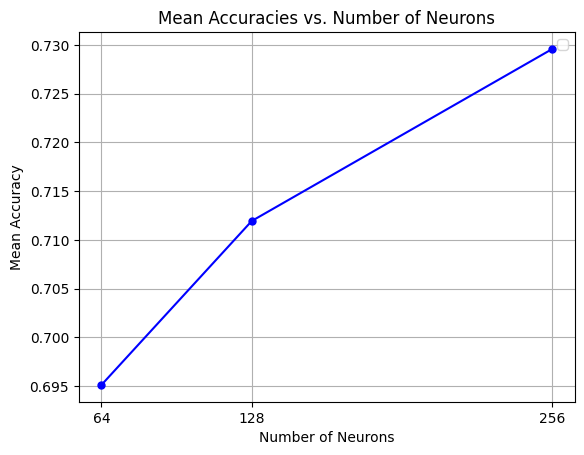

In [6]:
# YOUR CODE HERE
# print(cross_validation_accuracies)
# print(cross_validation_times)

# Calculate the mean accuracies for each element in num_neurons
num_neurons = [64, 128, 256]
mean_accuracies = []

for index, accuracies in cross_validation_accuracies.items():
    mean_accuracies.append(sum(accuracies) / len(accuracies))
    
# Create a scatterplot
#plt.scatter(num_neurons, mean_accuracies, label='Mean Accuracies', marker='x')
plt.plot(num_neurons, mean_accuracies, linestyle='-', marker='o', markersize=5, color='blue', label=None)
plt.xlabel('Number of Neurons')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracies vs. Number of Neurons')
plt.xticks(num_neurons)

plt.legend()
plt.grid(True)

# Show the plot
plt.show()
mean_times = [sum(values) / len(values) for key, values in cross_validation_times.items()]
df = pd.DataFrame({'Number of Neurons': num_neurons,
                   'Last Epoch Time':mean_times
                  })

# print(df)
# print(mean_accuracies)
# print(mean_times)

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [7]:
# print((mean_accuracies[2]-mean_accuracies[0])*100/mean_accuracies[0])
# print((mean_accuracies[1]-mean_accuracies[0])*100/mean_accuracies[0])
# print((mean_accuracies[2]-mean_accuracies[1])*100/mean_accuracies[1])

# print((mean_times[2]-mean_times[0])*100/mean_times[2])
# print((mean_times[1]-mean_times[0])*100/mean_times[1])
# print((mean_times[2]-mean_times[1])*100/mean_times[2])
# print(mean_accuracies)
# print(mean_times)

optimal_neurons = 256
reason = '''
The optimal number of neurons for the first hidden layer is 256 because it achieved the highest mean accuracy.
- 256 neurons has a slightly longer execution time as compared to 64 neurons, it is in acceptable range.  
- The significant lead in mean accuracy along with acceptable values for training time make 256 as the optimal number of neurons.
'''

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Epoch 1: Train_accuracy: 54.58%, Train_loss: 0.688624, Test_accuracy: 56.36%, Test_loss: 0.679628
Epoch 2: Train_accuracy: 58.50%, Train_loss: 0.673689, Test_accuracy: 59.54%, Test_loss: 0.669603
Epoch 3: Train_accuracy: 61.13%, Train_loss: 0.657360, Test_accuracy: 61.61%, Test_loss: 0.661191
Epoch 4: Train_accuracy: 62.97%, Train_loss: 0.645378, Test_accuracy: 61.69%, Test_loss: 0.656681
Epoch 5: Train_accuracy: 65.03%, Train_loss: 0.633327, Test_accuracy: 62.44%, Test_loss: 0.655609
Epoch 6: Train_accuracy: 67.61%, Train_loss: 0.615378, Test_accuracy: 64.95%, Test_loss: 0.637703
Epoch 7: Train_accuracy: 67.50%, Train_loss: 0.612179, Test_accuracy: 63.18%, Test_loss: 0.649828
Epoch 8: Train_accuracy: 68.99%, Train_loss: 0.600275, Test_accuracy: 63.76%, Test_loss: 0.639990
Epoch 9: Train_accuracy: 70.39%, Train_loss: 0.589646, Test_accuracy: 65.48%, Test_loss: 0.628482
Epoch 10: Train_accuracy: 72.39%, Train_loss: 0.574418, Test_accuracy: 66.53%, Test_loss: 0.626247
Epoch 11: Train_acc

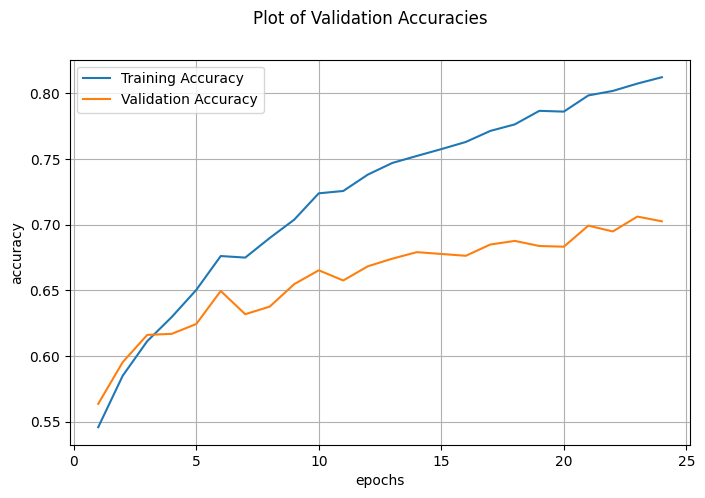

In [12]:
def preprocess(df):
    # YOUR CODE HERE
    # Split the dataset into training and testing sets (70:30 ratio)
    X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], test_size=0.3, random_state=0)

    # Preprocess the training and testing datasets
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

model = MLP(no_features=X_train_scaled.shape[1], no_hidden=256, no_labels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train_dataloader, test_dataloader = initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, 256)
early_stopper = EarlyStopper(patience=3, min_delta=0)
epochs = 100
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    if early_stopper.early_stop(test_loss):
        print('Done!')
        break
    
fig, ax2 = plt.subplots(figsize=(8, 5))  
fig.suptitle('Plot of Validation Accuracies')

ax2.plot(range(1, len(tr_correct) + 1), tr_correct, label='Training Accuracy')
ax2.plot(range(1, len(te_correct) + 1), te_correct, label='Validation Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.grid(True)
ax2.legend()

plt.show() 

In [15]:
result = '''
Batch size = 256
Number of neurons in first hidden layer of the neural network model = 256 

The training results over 24 epochs indicate a consistent improvement in both training and testing accuracy, as well as reductions in training and testing loss:

- The training accuracy steadily increased from 54.58% to 81.23%.

- Similarly, testing accuracy improved from 56.36% to 70.26%.

- Training loss consistently decreased, indicating that the model fitted the training data more effectively.
'''
model_path = "second_model.pth"

# Save the model to the specified file
torch.save(model.state_dict(), model_path)